In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scanpy as sc

In [4]:
from pathlib import Path
DATA = Path('/content/drive/My Drive/SML/02')

# Part 1: load data

In [ ]:
raw = pd.read_csv(DATA / "pbmc_6Kcells_500genes.txt", sep="\t", index_col=0)
raw

## 1a. Preprocessing and Umap

Data is already filtered

In [ ]:
# Converting to AnnData for use of Scanpy
adata = sc.AnnData(raw.transpose())
adata

AnnData object with n_obs × n_vars = 6825 × 500

In [ ]:
adata.obs['n_counts'] = np.sum(raw, axis=0)
adata.obs

In [ ]:
# Normalization
# The following normalizes the library size to median by default
sc.pp.normalize_per_cell(adata)
# adata.X.sum(axis=1)  # double check normalization result

In [ ]:
sc.settings.set_figure_params(dpi=100)

# Log transform the data
sc.pp.log1p(adata)

# Perform PCA
sc.tl.pca(adata)

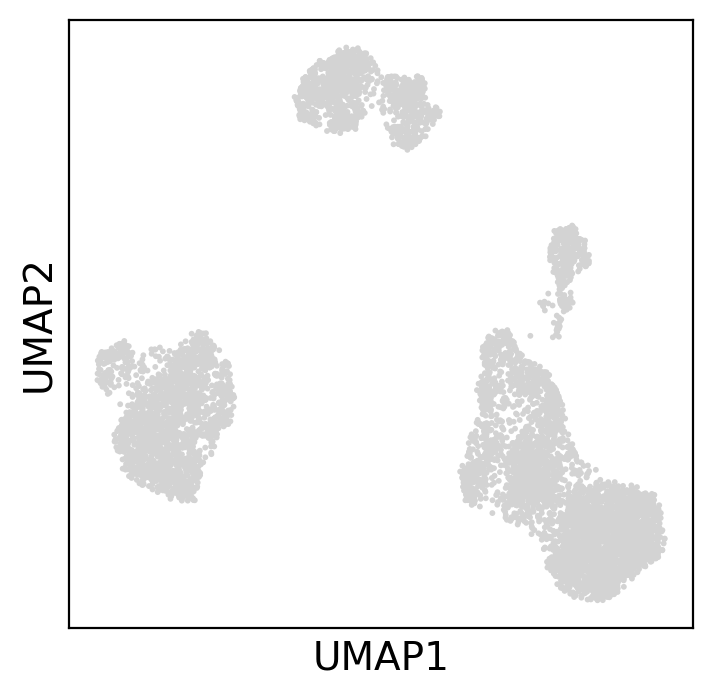

In [ ]:
# Umap with 20 PCs
sc.pp.neighbors(adata, n_pcs=20)  # necessary for scanpy to run umap
sc.tl.umap(adata)
sc.pl.umap(adata)

## 1b. PC choice

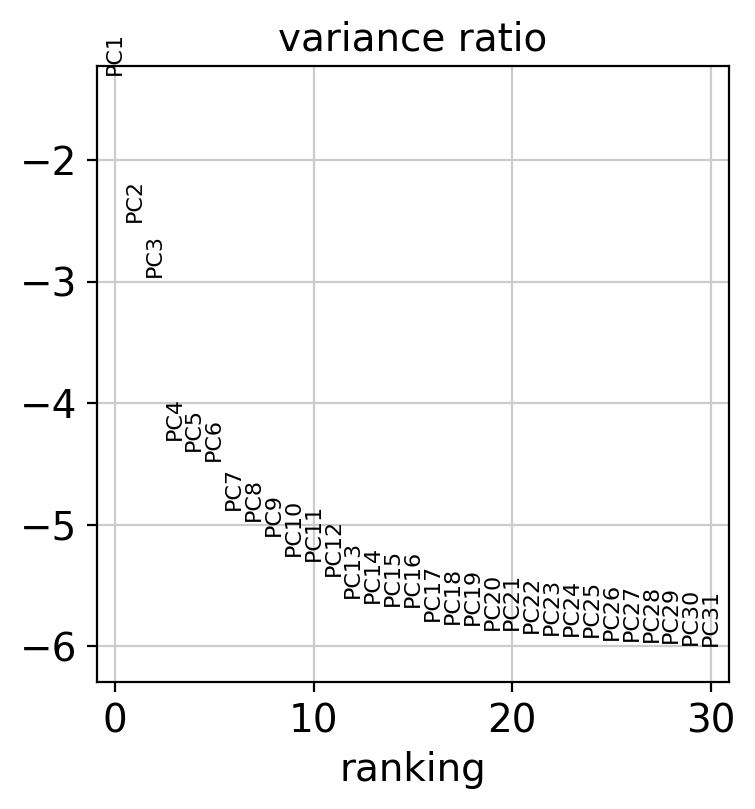

In [ ]:
# Variance ratio helps select the number of PCs in Umap
sc.pl.pca_variance_ratio(adata, log=True)

20 PCs is a good choice. The way to determine this is to plot PCA variance ratio. PCA replaces original variables with principal components, which have variances in decreasing order. After investigating the contribution to variance of each principle component, we know after 20 PCs, there is no significant variance contribution anymore, so 20 PCs is good.

# Part 2: Color with K-means

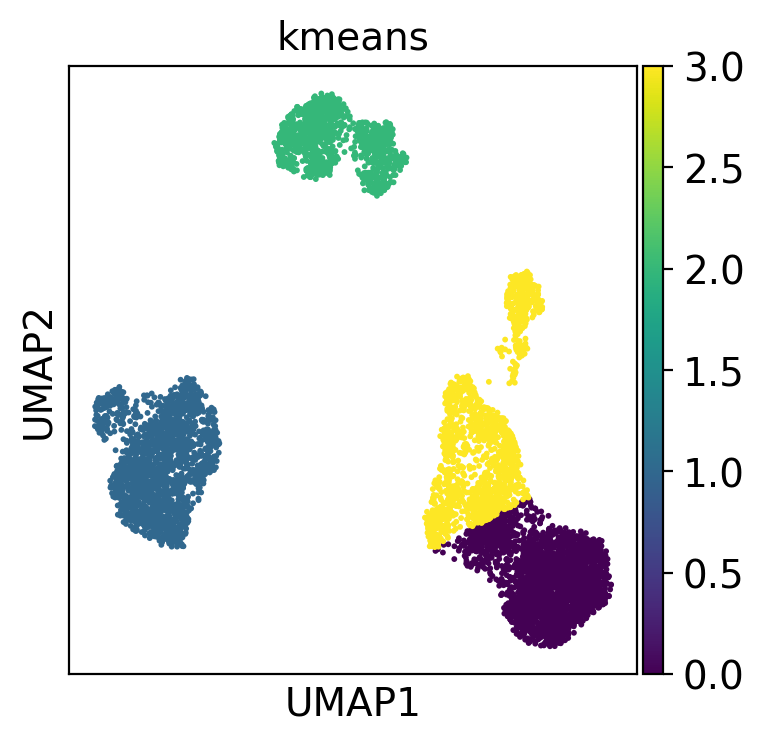

In [ ]:
umap_coordinates = adata.obsm['X_umap']
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates)

adata.obs['kmeans'] = kmeans.labels_

sc.pl.umap(adata, color='kmeans')

I chose K to be 4. The Umap shows that there are roughly 4 clusters, so K should be chosen accordingly. K-means group objects such that each belongs to one cluster, so K should match the number of clusters. Of couse, this does not color the clusters as we visually determine them because K-means is sensitive to issues, such as outliers. 

# Part 3: 30-NN

In [ ]:
# Reset AnnData without PCA for KNN
adata = sc.AnnData(raw.transpose())
adata.obs['n_counts'] = np.sum(raw, axis=0)
# The following normalizes the library size to median by default
sc.pp.normalize_per_cell(adata)
# Log transform the data
sc.pp.log1p(adata)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, knn=True, metric='correlation')

**Notice: I plotted the weighted adjacency matrix.** You can see it is faint. I also used a different function instead of heatmap to plot this, which is clearer.

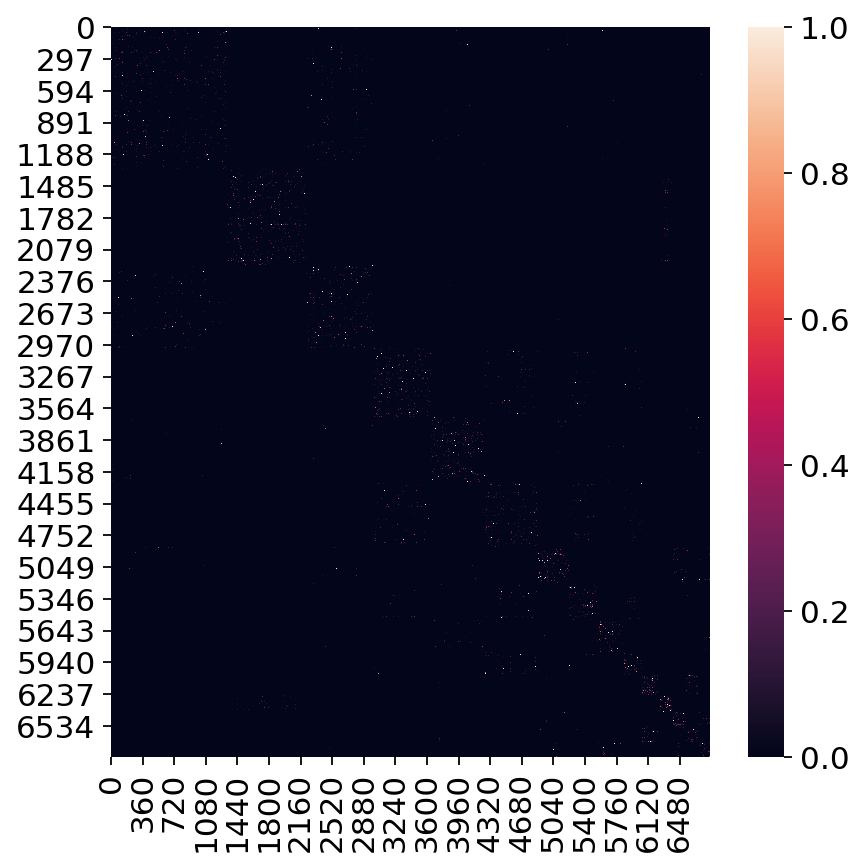

In [17]:
plt.figure(figsize=(6, 6))
sns.heatmap(adata.obsp['connectivities'].todense())

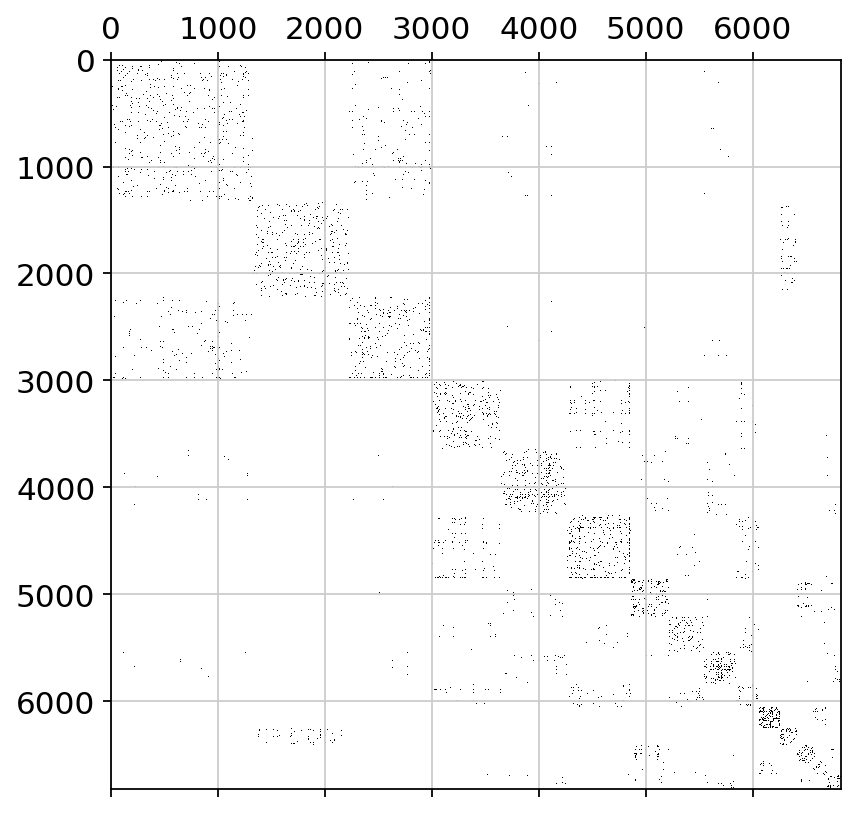

In [18]:
plt.figure(figsize=(6, 6))
plt.spy(adata.obsp['connectivities'].todense())

Another way to see a rough pattern of this matrix is to plot a downsampled version like the one below.

In [19]:
 # Downsample the adjacency matrix for easier plotting
 from scipy import sparse
 connect = adata.obsp['connectivities'].tocsc() # sparse operations are more efficient on csc
 N, M = connect.shape
 s, t = 200, 200 # decimation factors for y and x directions
 T = sparse.csc_matrix((np.ones((M,)), 
                        np.arange(M), 
                        np.r_[np.arange(0, M, t), M]), 
                       (M, (M-1) // t + 1))
 S = sparse.csr_matrix((np.ones((N,)), 
                        np.arange(N), 
                        np.r_[np.arange(0, N, s), N]), 
                       ((N-1) // s + 1, N))
 result = S @ connect @ T # downsample by binning into s x t rectangles
 result = result.todense() # ready for plotting

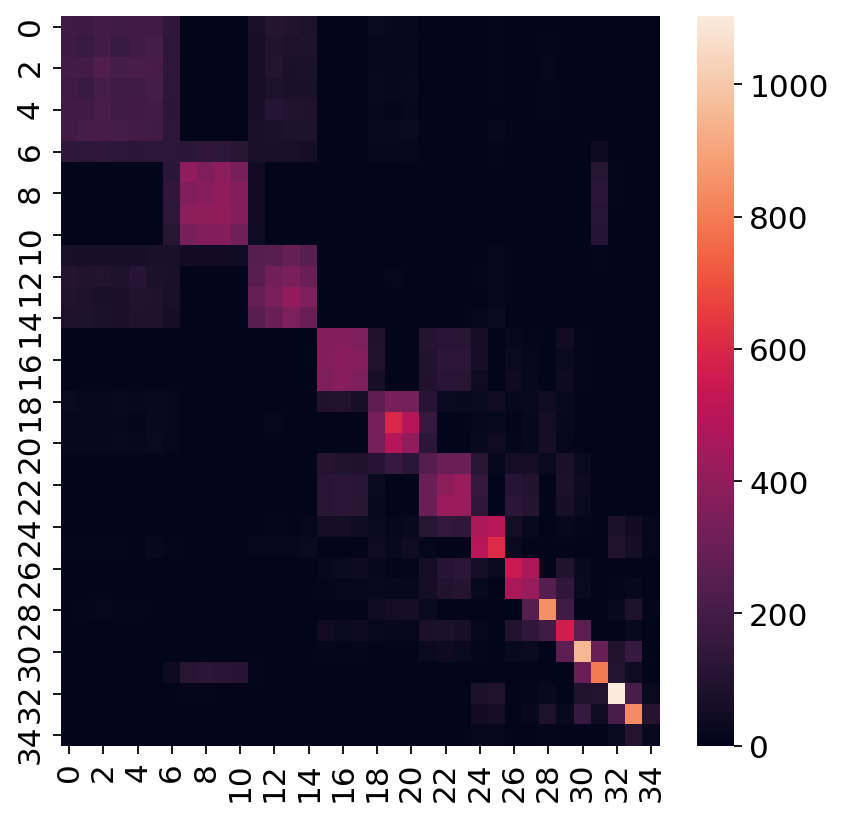

In [20]:
plt.figure(figsize=(6, 6))
sns.heatmap(result)

## Selection of distance metric

I used the 'correlation' metric instead of the default 'euclidean' metric because euclidean is senstive to scaling and differences in average expression level while correlation does not suffer from these issues. 

# Part 4: Louvain

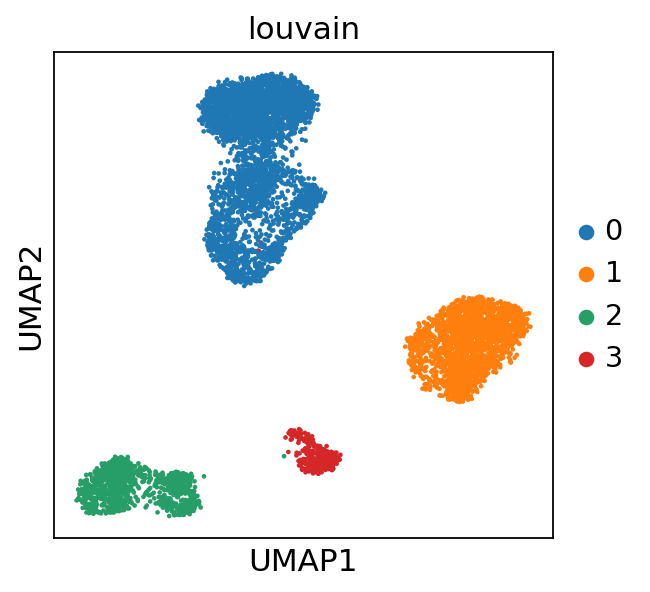

In [21]:
sc.tl.louvain(adata, resolution=0.1)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['louvain'])

Comparing this plot with K-means back then, we can see that K-means is sensitive to outliers. Louvain does a much better job to characterize the clusters. Louvain clustering matches how we expect them to be clustered based on the pattern. This is because K-means aims to partition the observations with their nearest means. Louvain maximizes modularity. In general, this kind of graph-based clustering is more powerful. 

# Part 5 Differentially expressed genes (DEGs)

## 5a. T-test

In [22]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
deg = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
deg.head()

,0,1,2,3
0,TRAC,LYZ,CD74,NKG7
1,CD3D,FTL,HLA-DRA,GNLY
2,CD3E,CST3,CD79A,HLA-B
3,IL32,TYROBP,HLA-DPA1,KLRD1
4,LDHB,S100A9,CD79B,CTSW


### Choose the first cluster to investigate

In [23]:
print(deg.iloc[0:5, 0])

0    TRAC
1    CD3D
2    CD3E
3    IL32
4    LDHB
Name: 0, dtype: object


The top five DEGs of the first cluster are TRAC, CD3D, CD3E, IL32, and LDHB.

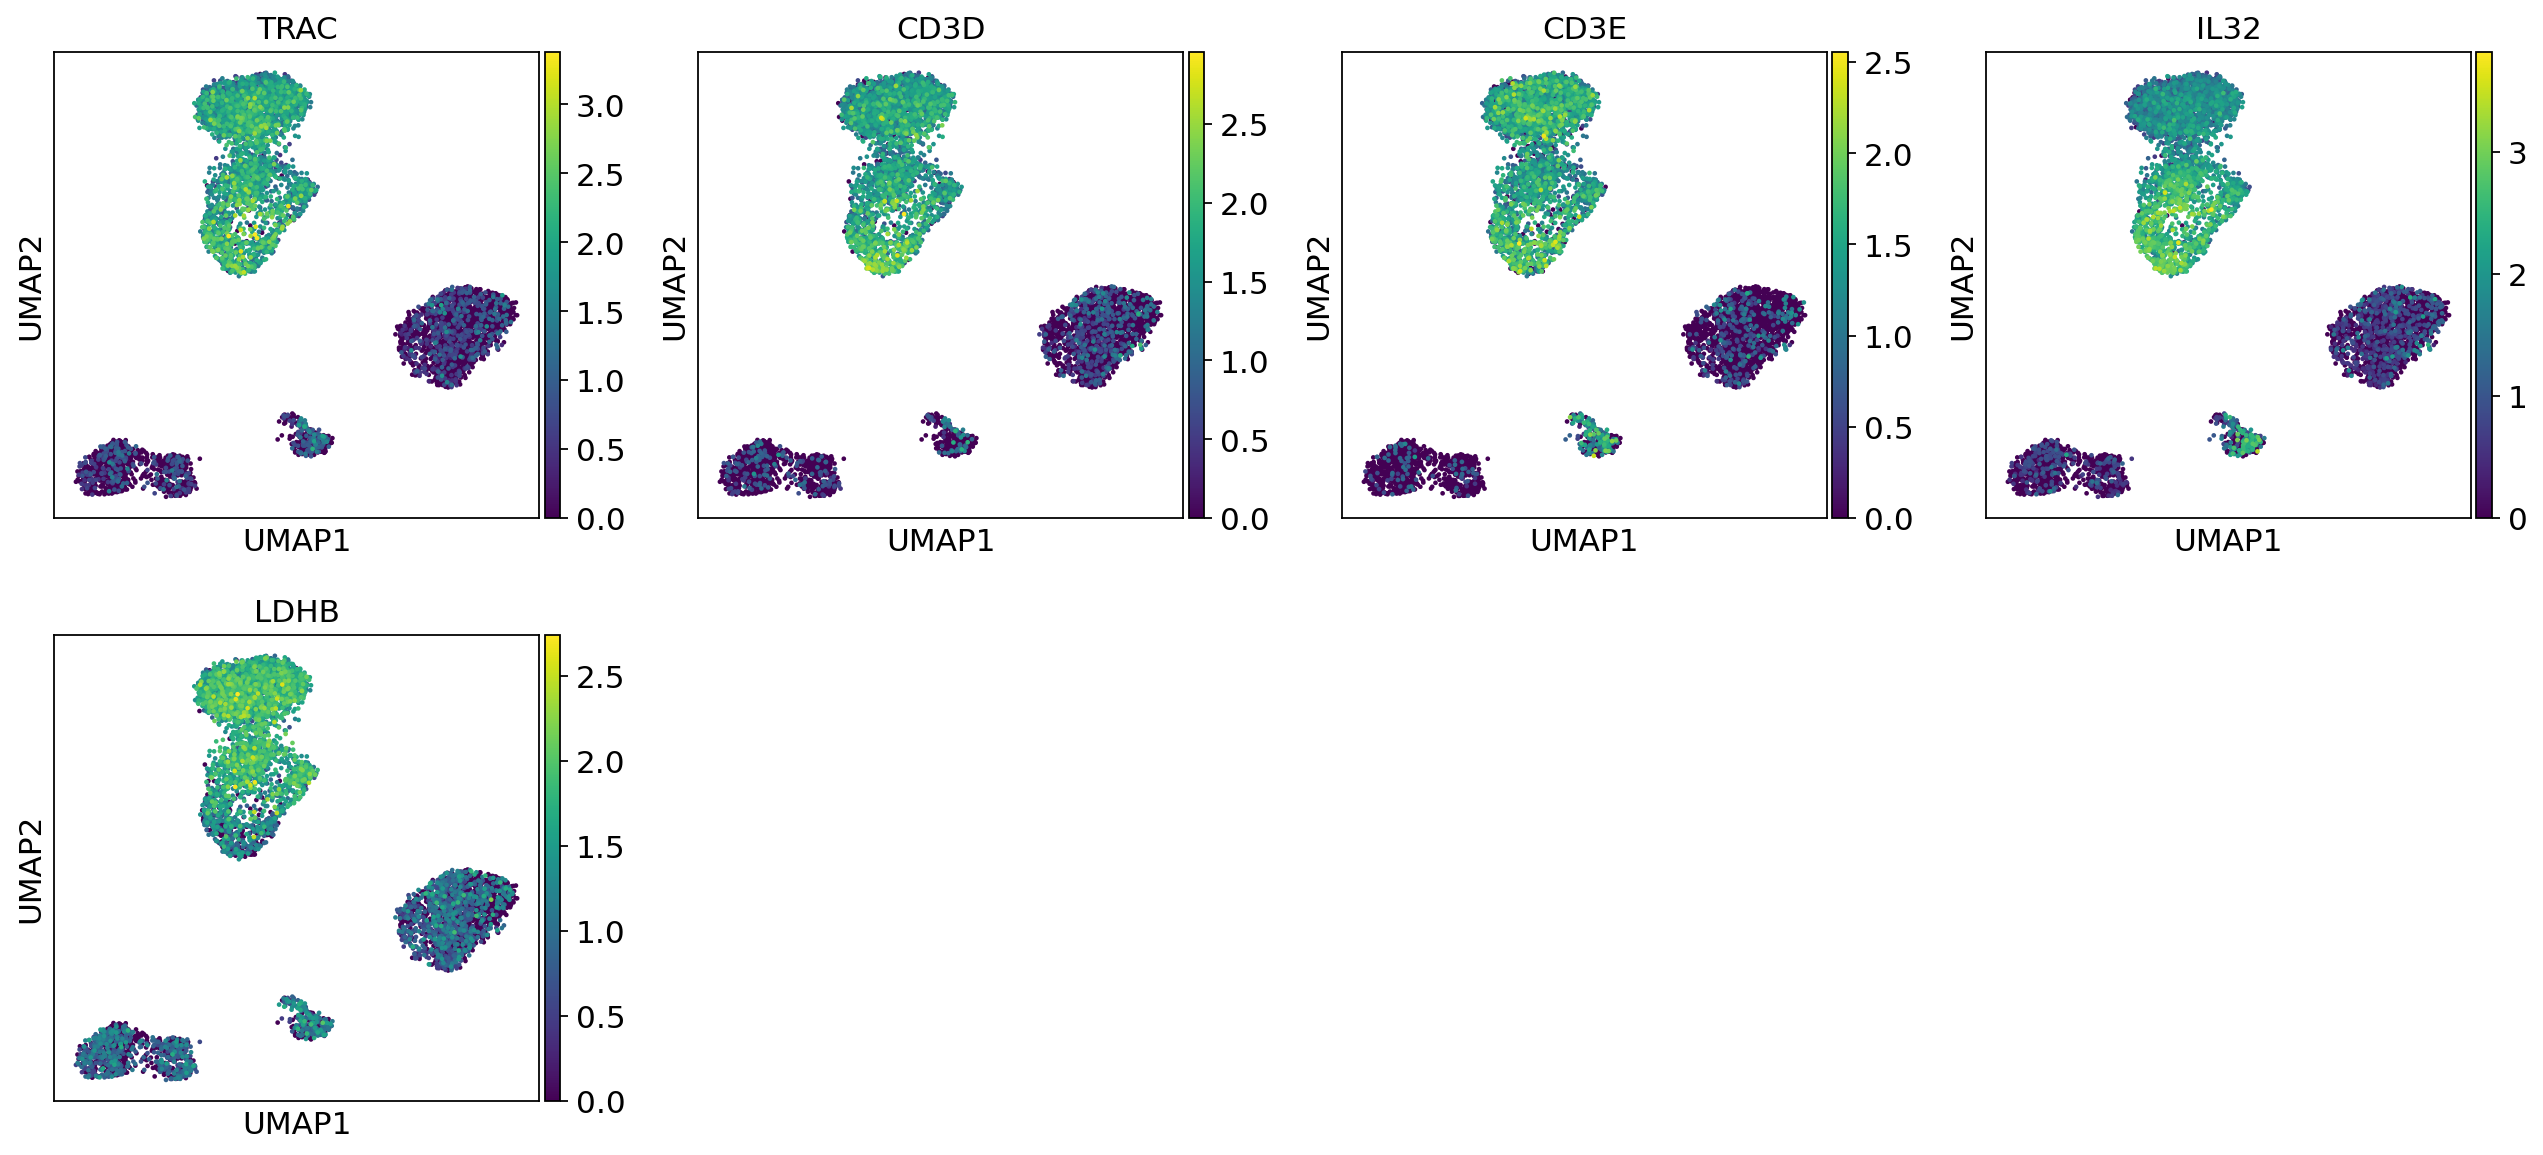

In [24]:
sc.settings.set_figure_params(dpi=80)
sc.pl.umap(adata, color=deg.iloc[0:5, 0])

## 5b. 

From the top genes differentially expressed, we can tell that the first cluster should be T-cells. They are T-cell receptor or surface proteins. 

## 5c. A different method

Instead of t-test, I performed a non-parametric test, Wilcoxon. The advantage is that we don't need to assume normal distribution (of course, our data is already normalized, so this might not be a big advantage anymore). Of course, for single cells, there are a lot of zero values, so putting them into ranks can sometimes be inaccurate. Based on the results below, this method performs reasonably well. 

In [25]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
deg_diff = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
deg_diff.head()

,0,1,2,3
0,TRAC,LYZ,CD74,NKG7
1,CD3D,S100A9,CD79A,GNLY
2,IL32,CST3,CD79B,KLRD1
3,CD3E,FTL,MS4A1,CTSW
4,RPS29,S100A8,HLA-DPA1,PRF1


### Look at DEGs in the first cluster again

They are not very different from the result of t-test. The last gene performs less well than t-test. The other genes are the same.

In [26]:
print(deg_diff.iloc[0:5, 0])

0     TRAC
1     CD3D
2     IL32
3     CD3E
4    RPS29
Name: 0, dtype: object


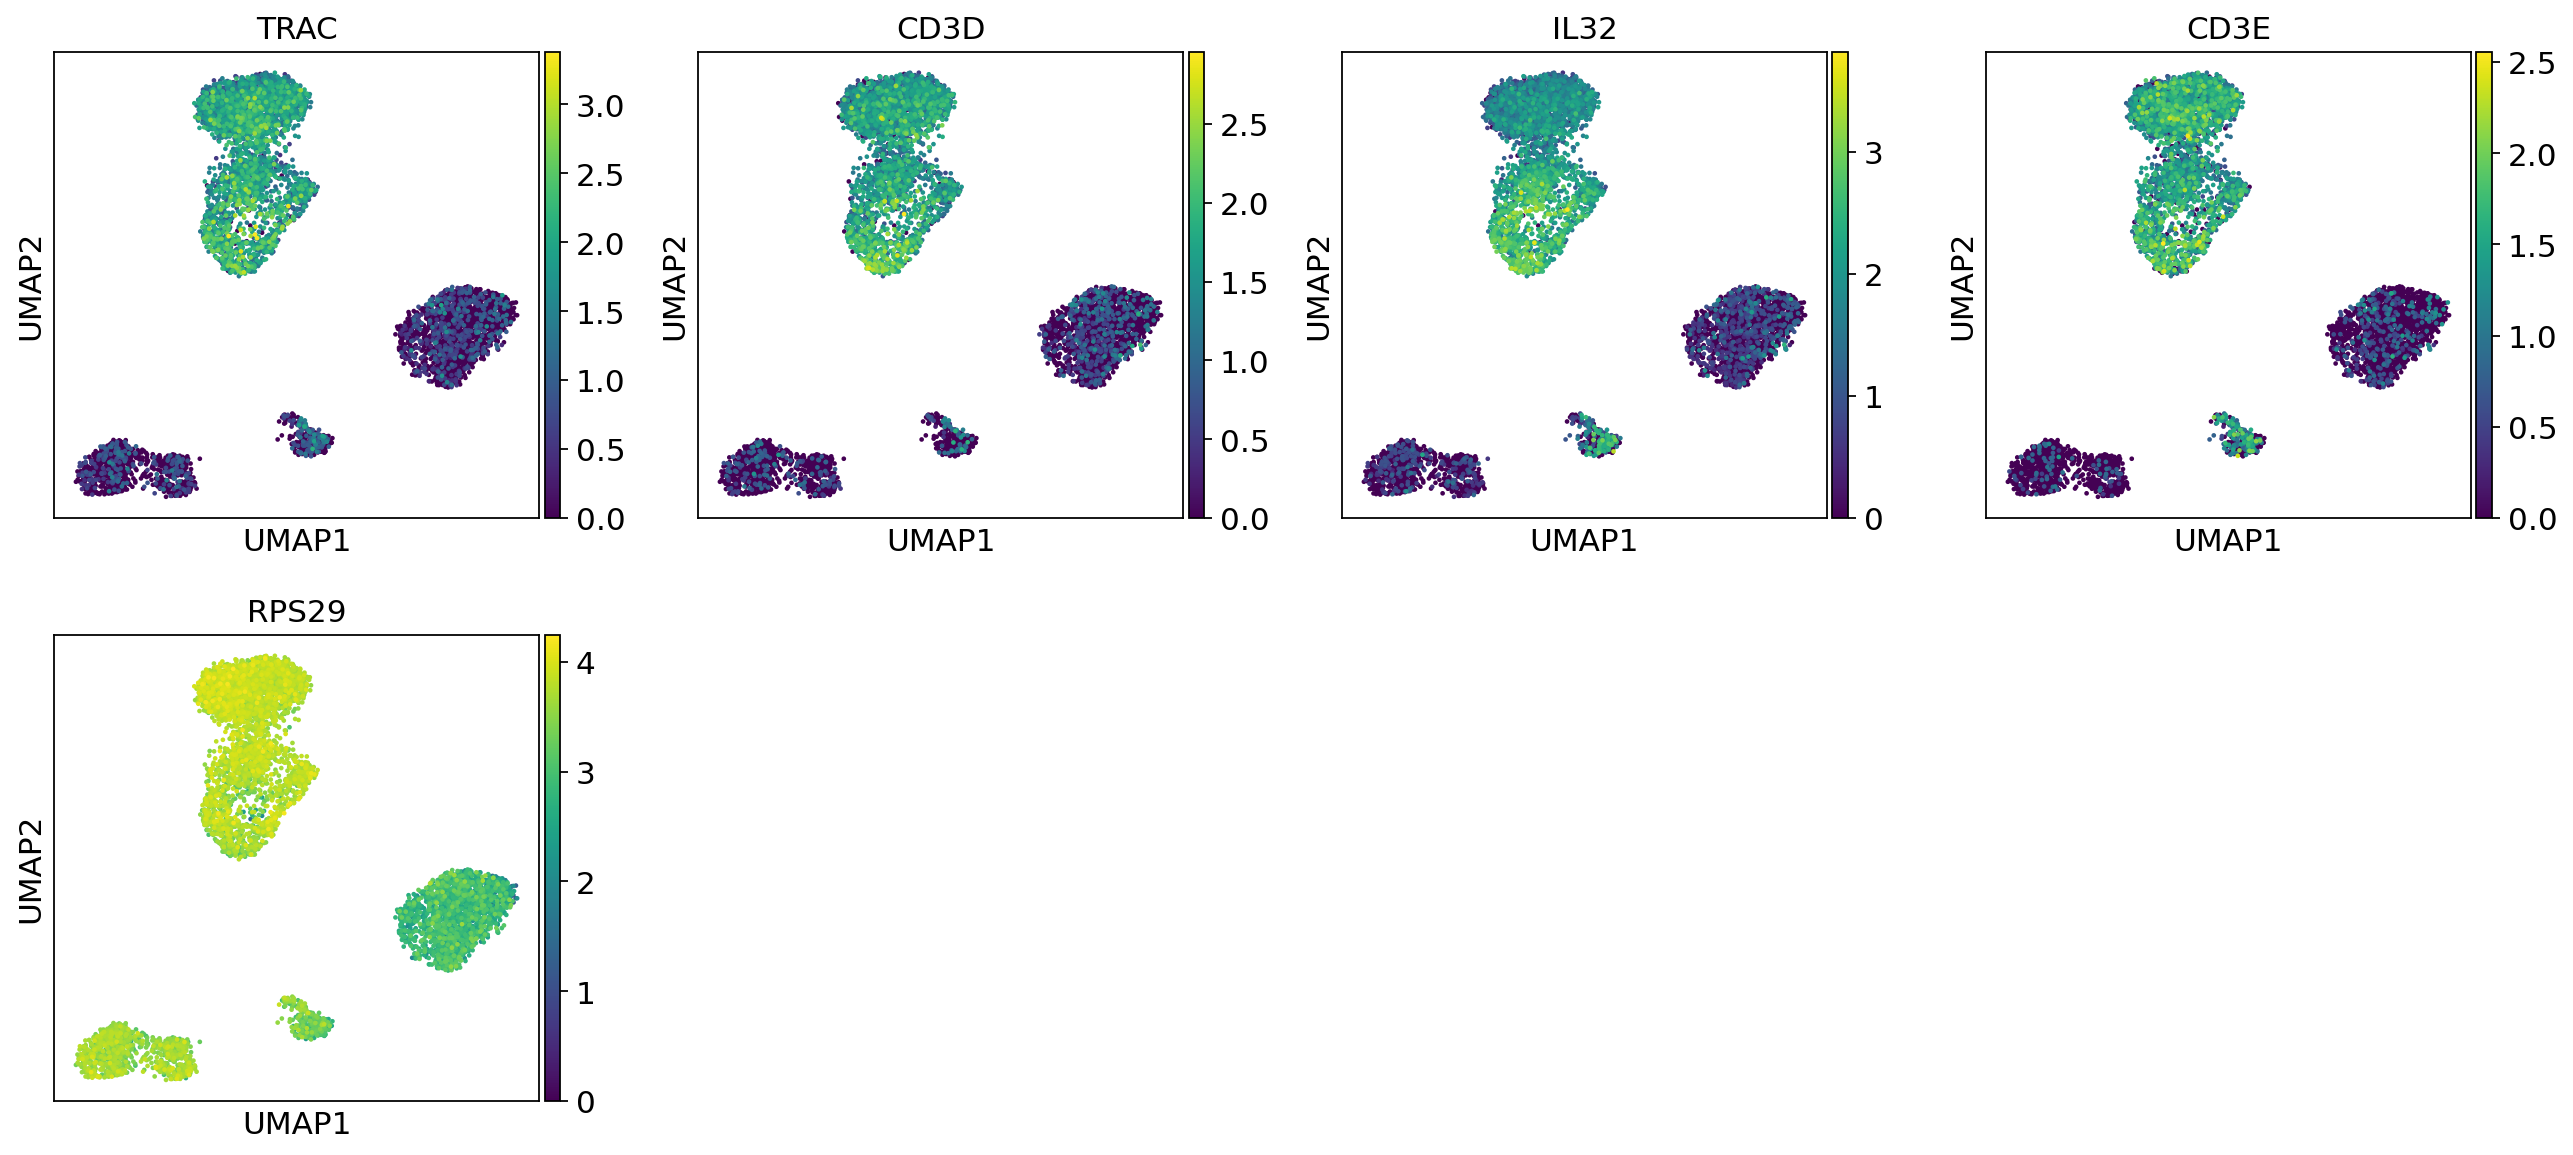

In [27]:
sc.pl.umap(adata, color=deg_diff.iloc[0:5, 0])